# Death to Cluster Models; Long Live Context Encoders
Outline:
- Regression: population vs. cluster vs. context-specific models (compared on MSE and L2)
- Networks: population vs. cluster vs. context-specific models (compared on L2)

We don't see all values of context but with a context encoder we can fill in the gaps rather than referring to the nearest cluster. This is important because gaps often represent:

- Undersampled / underrepresented patient populations
- Undocumented / undiscovered treatments
- Rare cell types / diseases / risk factors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.cluster import KMeans
from contextualized.regression import ContextualizedRegression, RegressionTrainer

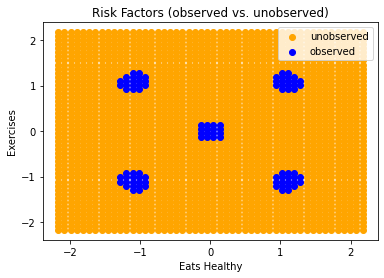

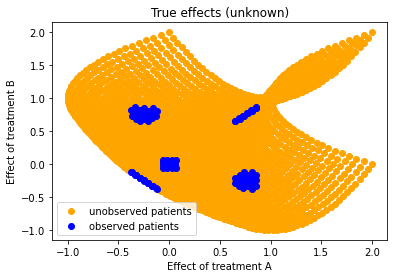

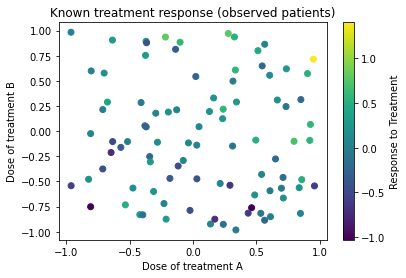

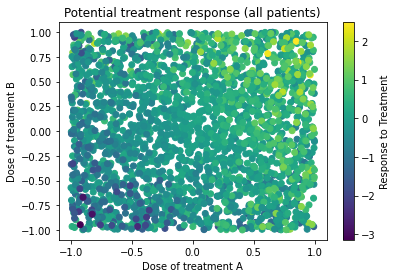

In [2]:
n_z = 50
Z_space = np.linspace(-1, 1, n_z)
Z = np.zeros((n_z**2, 2))
for i, z_i in enumerate(Z_space):
    for j, z_j in enumerate(Z_space):
        Z[i * n_z + j] = [z_i, z_j]
z_samples = 1
Z_labels = np.repeat(Z, z_samples, axis=0)
C = Z_labels.copy()

W = np.zeros_like(Z_labels)
W[:,0] = C[:,0] + C[:,1]**2 
W[:,1] = C[:,0]**2 + C[:,1] 
W = np.repeat(W, z_samples, axis=0)
# W += np.random.normal(0, .1, W.shape)
X = np.random.uniform(-1, 1, W.shape)
Y = (X * W).sum(axis=1)[:, np.newaxis]
Y += np.random.normal(0, .1, Y.shape)

def get_idx(Z):
    dist = lambda a, b: np.sqrt(np.sum((a - b)**2)) 
    gap_centers = np.array([
        [0, 0],
        [.5, .5],
        [.5, -.5],
        [-.5, .5],
        [-.5, -.5],
    ])
    gap_radius = .1
    gap_idx = np.ones(len(Z))
    for i, z in enumerate(Z):
        for gap_center in gap_centers:
            if dist(z, gap_center) < gap_radius:
                gap_idx[i] = 0
    return gap_idx
    
    
gap_idx = get_idx(Z_labels)
train_idx, test_idx = gap_idx == 0, gap_idx == 1
split = lambda arr: (arr[train_idx], arr[test_idx])
Z_train, Z_test = split(Z_labels)
C_train, C_test = split(C)
C_mean, C_std = C_train.mean(axis=0), C_train.std(axis=0)
C_train = (C_train - C_mean) / C_std
C_test = (C_test - C_mean) / C_std
W_train, W_test = split(W)
X_train, X_test = split(X)
Y_train, Y_test = split(Y)

plt.scatter(C_test[:,0], C_test[:,1], c='orange', label='unobserved')
plt.scatter(C_train[:,0], C_train[:,1], c='blue', label='observed')
plt.xlabel('Eats Healthy')
plt.ylabel('Exercises')
plt.title('Risk Factors (observed vs. unobserved)')
plt.legend()
plt.show()
# plt.scatter(W[:,0], W[:,1], c=gap_idx)

plt.scatter(W_test[:,0], W_test[:,1], c='orange', label='unobserved patients')
plt.scatter(W_train[:,0], W_train[:,1], c='blue', label='observed patients')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('True effects (unknown)')
plt.legend()
plt.show()

plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.xlabel('Dose of treatment A')
plt.ylabel('Dose of treatment B')
plt.colorbar(label='Response to Treatment')
plt.title('Known treatment response (observed patients)')
plt.show()

plt.scatter(X[:,0], X[:,1], c=Y)
plt.xlabel('Dose of treatment A')
plt.ylabel('Dose of treatment B')
plt.colorbar(label='Response to Treatment')
plt.title('Potential treatment response (all patients)')
plt.show()
# plt.scatter(X[:,0], X[:,1], c=gap_idx)
# plt.show()

In [6]:
# Models
mse = lambda true, pred: ((true - pred)**2).mean()

class NaiveRegression:
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        self.w = np.linalg.inv(X.T @ X) @ X.T @ Y
        return self
        
    def predict_w(self, X):
        return np.tile(self.w.T, (len(X), 1))
    
    def predict_y(self, X):
        w_hat = self.predict_w(X)
        y_hat = (X * w_hat).sum(axis=1)[:, np.newaxis]
        return y_hat


class ClusterRegression:
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K)
        self.models = {k: NaiveRegression() for k in range(K)}
    
    def fit(self, C, X, Y):
        self.kmeans.fit(C)
        for k in range(self.K):
            k_idx = self.kmeans.labels_ == k
            X_k, Y_k = X[k_idx], Y[k_idx]
            self.models[k].fit(X_k, Y_k)
        return self
            
    def predict_l(self, C):
        return self.kmeans.predict(C)
    
    def predict_w(self, C, X):
        labels = self.predict_l(C)
        w_hat = np.zeros_like(X)
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            w_hat[l_idx] = self.models[label].predict_w(X_l)
        return w_hat
    
    def predict_y(self, C, X):
        labels = self.predict_l(C)
        y_hat = np.zeros((len(X), 1))
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            y_hat[l_idx] = self.models[label].predict_y(X_l)
        return y_hat

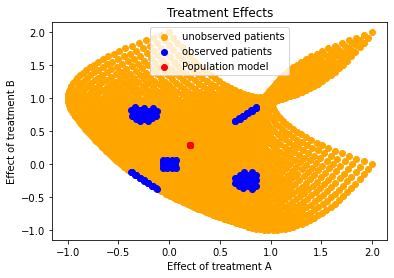

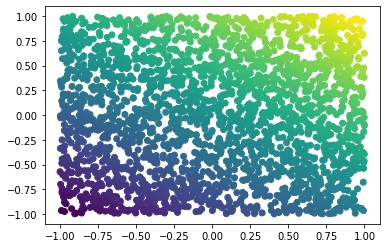

Treatment-response error: 	0.3286750603223562
Effect-size error: 		0.4632449673286351


In [4]:
# Population regression
naive_model = NaiveRegression().fit(X_train, Y_train)
w_hat = naive_model.predict_w(X_test)
y_hat = naive_model.predict_y(X_test)

plt.scatter(W_test[:,0], W_test[:,1], c='orange', label='unobserved patients')
plt.scatter(W_train[:,0], W_train[:,1], c='blue', label='observed patients')
plt.scatter(w_hat[:,0], w_hat[:,1], c='red', label='Population model')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('Treatment Effects')
plt.legend()
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Treatment-response error: \t{y_mse}")
print(f"Effect-size error: \t\t{w_mse}")

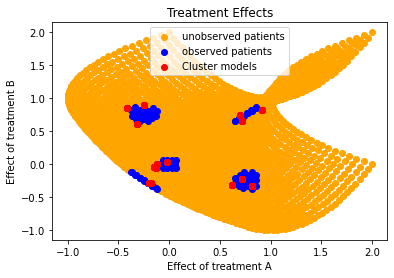

Treatment-response error: 	0.13366162834127665
Effect-size error: 		0.18784222984179968


In [5]:
# Cluster regression
cluster_model = ClusterRegression(15).fit(C_train, X_train, Y_train)
w_hat = cluster_model.predict_w(C_test, X_test)
y_hat = cluster_model.predict_y(C_test, X_test)

plt.scatter(W_test[:,0], W_test[:,1], c='orange', label='unobserved patients')
plt.scatter(W_train[:,0], W_train[:,1], c='blue', label='observed patients')
plt.scatter(w_hat[:,0], w_hat[:,1], c='red', label='Cluster models')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('Treatment Effects')
plt.legend()
plt.show()

# plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
# plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Treatment-response error: \t{y_mse}")
print(f"Effect-size error: \t\t{w_mse}")

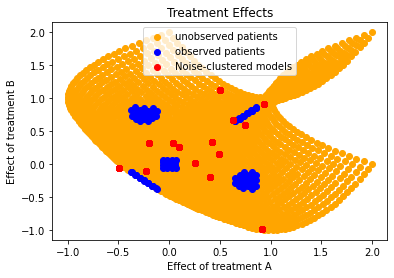

Response error: 0.4419725165169365
Effect-size error: 0.6180172881432756


In [7]:
# Regression from noise-context clustering
noise = np.random.normal(0, 1, C.shape)
noise_train, noise_test = split(noise)
noise_mean, noise_std = noise_train.mean(axis=0), noise_train.std(axis=0)
noise_train = (noise_train - noise_mean) / noise_std
noise_test = (noise_test - noise_mean) / noise_std

cluster_model = ClusterRegression(14).fit(noise_train, X_train, Y_train)
w_hat = cluster_model.predict_w(noise_test, X_test)
y_hat = cluster_model.predict_y(noise_test, X_test)

plt.scatter(W_test[:,0], W_test[:,1], c='orange', label='unobserved patients')
plt.scatter(W_train[:,0], W_train[:,1], c='blue', label='observed patients')
plt.scatter(w_hat[:,0], w_hat[:,1], c='red', label='Noise-clustered models')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('Treatment Effects')
plt.legend()
plt.show()

# plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
# plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 690   
-----------------------------------------------
690       Trainable params
0         Non-trainable params
690       Total params
0.003     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing

Training: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 92it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


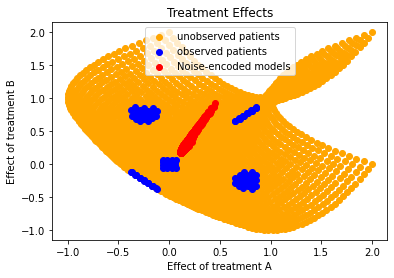

Response error: 0.3385282078488547
Effect-size error: 0.47822391107055157


In [8]:
# Regression from noise encoding
encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(noise.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(noise_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(noise_test, X_test, Y_test, batch_size=100)
trainer = RegressionTrainer(max_epochs=5, auto_lr_find=True)
trainer.fit(model, train_dataloader)

w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

plt.scatter(W_test[:,0], W_test[:,1], c='orange', label='unobserved patients')
plt.scatter(W_train[:,0], W_train[:,1], c='blue', label='observed patients')
plt.scatter(w_hat[:,0], w_hat[:,1], c='red', label='Noise-encoded models')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('Treatment Effects')
plt.legend()
plt.show()

# plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
# plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 690   
-----------------------------------------------
690       Trainable params
0         Non-trainable params
690       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 92it [00:00, ?it/s]

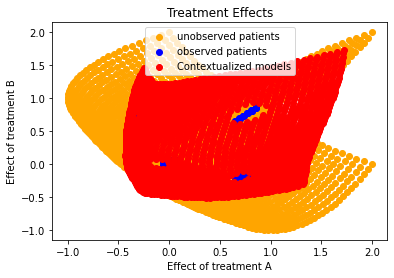

Response error: 0.05516677574570457
Effect-size error: 0.06801622028237361


In [11]:
# Regression from context

# C_new = np.concatenate((C, noise), axis=-1)
C_new = C.copy()
C_new_train, C_new_test = split(C_new)

encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(C_new.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(C_new_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(C_new_test, X_test, Y_test, batch_size=100)
trainer = RegressionTrainer(max_epochs=100, auto_lr_find=True)
trainer.fit(model, train_dataloader)

w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

plt.scatter(W_test[:,0], W_test[:,1], c='orange', label='unobserved patients')
plt.scatter(W_train[:,0], W_train[:,1], c='blue', label='observed patients')
plt.scatter(w_hat[:,0], w_hat[:,1], c='red', label='Contextualized models')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('Treatment Effects')
plt.legend()
plt.show()

# plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
# plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 790   
-----------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 92it [00:00, ?it/s]

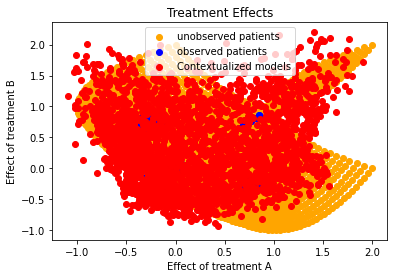

Response error: 0.0647176549367971
Effect-size error: 0.08015010961575522


In [10]:
# Regression from context with noise

C_new = np.concatenate((C, noise), axis=-1)
C_new_train, C_new_test = split(C_new)

encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(C_new.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(C_new_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(C_new_test, X_test, Y_test, batch_size=100)
trainer = RegressionTrainer(max_epochs=100, auto_lr_find=True)
trainer.fit(model, train_dataloader)

w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

plt.scatter(W_test[:,0], W_test[:,1], c='orange', label='unobserved patients')
plt.scatter(W_train[:,0], W_train[:,1], c='blue', label='observed patients')
plt.scatter(w_hat[:,0], w_hat[:,1], c='red', label='Contextualized models')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('Treatment Effects')
plt.legend()
plt.show()

# plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
# plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

# Networks
- Bayesian networks: y = w(c) * x + eps
- Correlation networks: y = w(c) * x + eps(C)

In [3]:
import tensorflow as tf

# import contextualized
# import importlib
# importlib.reload(contextualized)
# NOTMAD = contextualized.notmad.NOTMAD
# NOTEARS = contextualized.notmad_helpers.baselines.NOTEARS
# ClusteredNOTEARS = contextualized.notmad_helpers.baselines.ClusteredNOTEARS
# graph_utils = contextualized.notmad_helpers.graph_utils

from contextualized.notmad import NOTMAD
from contextualized.notmad_helpers.baselines import NOTEARS, ClusteredNOTEARS
from contextualized.notmad_helpers import graph_utils, simulation

<module 'contextualized.notmad_helpers.graph_utils' from '/Users/calebellington/Workbench/Contextualized/contextualized/notmad_helpers/graph_utils.py'>

In [127]:
n = 100
C = np.linspace(0, 1, n).reshape((n, 1))
blank = np.zeros_like(C)
W_00 = blank
W_01 = (C - .5)
# W_01 = np.ones_like(C)
W_02 = blank
W_03 = C
W_10 = blank
W_11 = blank
W_12 = blank
W_13 = C**2
W_20 = blank
W_21 = blank
W_22 = blank
W_23 = blank
W_30 = blank
W_31 = blank
W_32 = blank
W_33 = blank
W = np.array([
    [W_00, W_01, W_02, W_03],
    [W_10, W_11, W_12, W_13],
    [W_20, W_21, W_22, W_23],
    [W_30, W_31, W_32, W_33],
]).squeeze()
W = np.transpose(W, (2, 0, 1))

dag_pred = lambda x, w: tf.matmul(x, w).numpy().squeeze()
X_pre = np.random.normal(0, 1, (n, 4))
# eps = np.random.normal(0, .1, (n, 4))
X = np.zeros_like(X_pre)
for i, (w, X_p) in enumerate(zip(W, X_pre)):
    eps = np.random.normal(0, .01, 4)
    X_new = dag_pred(X_p[np.newaxis, :], w)
    X[i] = X_new + eps

idx = np.logical_and(C > .7, C < .9).squeeze()
test_idx = np.argwhere(idx).squeeze()
train_idx = np.argwhere(~idx).squeeze()
split = lambda arr: (arr[train_idx], arr[test_idx])
W_train, W_test = split(W)
C_train, C_test = split(C)
X_train, X_test = split(X)

In [128]:
# Population Model
loss_params = {'l1': 1e-2, 'init_alpha': 1e-1, 'init_rho': 1e-2}

notears = NOTEARS(loss_params, C_train.shape, W_train.shape[1:])
notears.fit(C_train, X_train, epochs=15, batch_size=100)

naive_preds_train = notears.predict_w(C_train, project_to_dag=True).squeeze()
naive_preds = notears.predict_w(C_test, project_to_dag=True).squeeze()
print(f"train l2:  {mse(naive_preds_train, W_train)}")
print(f"test l2:   {mse(naive_preds, W_test)}")
print(f"train mse: {mse(dag_pred(X_train, naive_preds_train), X_train)}")
print(f"test mse:  {mse(dag_pred(X_test, naive_preds), X_test)}")

NOTEARS Training:   0%|                                 0/15 ETA: ?s,  ?epochs/s

train l2:  0.030634735844755928
test l2:   0.07397189233660048
train mse: 0.09001858295670935
test mse:  0.3544741569734166


In [129]:
naive_preds_train[0]

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.3837672e-04,  0.0000000e+00,  2.0456480e-04, -8.4995897e-03],
       [-3.9292179e-05,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-6.0969003e-05,  0.0000000e+00,  1.1820000e-04,  0.0000000e+00]],
      dtype=float32)

In [130]:
# Cluster Model
clustered_notears = ClusteredNOTEARS(
    10, loss_params, C_train.shape, W_train.shape[1:]
)
clustered_notears.fit(C_train, X_train, epochs=15, batch_size=100)

clustered_preds_train = clustered_notears.predict_w(C_train, project_to_dag=True).squeeze()
clustered_preds = clustered_notears.predict_w(C_test, project_to_dag=True).squeeze()
print(f"train l2: {mse(clustered_preds_train, W_train)}")
print(f"test l2:  {mse(clustered_preds, W_test)}")
print(f"train mse: {mse(dag_pred(X_train, clustered_preds_train), X_train)}")
print(f"test mse:  {mse(dag_pred(X_test, clustered_preds), X_test)}")


Clustered NOTEARS Training: 100%|███████████████| 10/10 [00:21<00:00,  2.16s/it]

train l2: 0.03018082742189011
test l2:  0.07249841963418595
train mse: 0.08990512183305509
test mse:  0.35160853926724056


In [131]:
clustered_preds_train[0]

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.3691443e-04,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.4820383e-05,  1.6333524e-04,  0.0000000e+00,  0.0000000e+00],
       [-7.2612020e-05, -8.6090369e-03,  1.4972719e-04,  0.0000000e+00]],
      dtype=float32)

In [135]:
def fit_notmad(sample_specific_loss_params, archetype_loss_params, 
                  C_train, X_train, k, project, notears_pop, base_predictor):
    init_mat = np.random.uniform(-0.01, 0.01, size=(k, X_train.shape[-1], X_train.shape[-1])) #np.zeros((k, X_train.shape[-1], X_train.shape[-1])) #
    make_notmad = lambda: NOTMAD(
        C_train.shape, X_train.shape, k,
        sample_specific_loss_params, archetype_loss_params,
        n_encoder_layers=2, encoder_width=32,
        activation='linear', init_mat=init_mat,
        learning_rate=1e-3, project_archs_to_dag=project, # TODO: should this be variable?
        project_distance=1.0,
        context_activity_regularizer=tf.keras.regularizers.l1(0),
        use_compatibility=False, update_compat_by_grad=False,
        pop_model=None, base_predictor=base_predictor
    )
    notmad = make_notmad()
    notmad.fit(
        C_train, X_train, batch_size=1, epochs=100, 
        es_patience=None, verbose=1
    )
    return notmad

k = 5
loss_params = {'l1': 1e-3, 'init_alpha': 1e-1, 'init_rho': 1e-2}
# loss_params = {'l1': 1e-2, 'alpha': 1e-1, 'rho': 1e-2}
archetype_loss_params = {'l1': 1e-3, 'alpha': 1e-1, 'rho': 1e-2}
notmad = fit_notmad(
    loss_params, archetype_loss_params,
    C_train, X_train, k, project=True, 
    notears_pop=None, base_predictor=notears
)

# estimating transposed networks?
notmad_preds_train = notmad.predict_w(C_train, project_to_dag=True).squeeze()
notmad_preds = notmad.predict_w(C_test, project_to_dag=True).squeeze()
print(f"train l2: {mse(notmad_preds_train, W_train)}")
print(f"test l2:  {mse(notmad_preds, W_test)}")
print(f"train mse: {mse(dag_pred(X_train, notmad_preds_train), X_train)}")
print(f"test mse:  {mse(dag_pred(X_test, notmad_preds), X_test)}")

NOTMAD Training:   0%|                                 0/100 ETA: ?s,  ?epochs/s

train l2: 0.09698269094449985
test l2:  0.19516397022227736
train mse: 0.11852870625944066
test mse:  0.5181592311281801


In [137]:
print(notmad_preds_train[0].T)

[[ 0.0000000e+00 -4.7425769e-04 -2.4961127e-04  4.3439187e-04]
 [ 0.0000000e+00  0.0000000e+00  1.3048213e-04 -5.8546788e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.4190790e-03  0.0000000e+00]]


## Correlation nets

In [ ]:
from contextualized.networks import ContextualizedCorrelation, NetworkTrainer

Global correlation: [[0.95686338]]


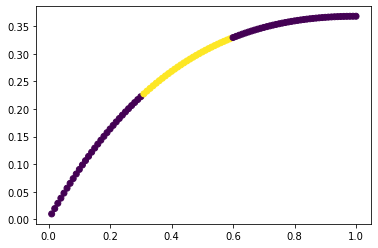

In [14]:
n = 100
C = np.linspace(.01, 1, n).reshape((n, 1))
w = np.exp(-C)
X = np.linspace(.01, 1, n).reshape((n, 1))
# eps = np.random.normal(0, C*.1, (n, 1))
# Y = X * w + eps
Y = X * w
V = np.concatenate((X, Y), axis=-1)

idx = np.logical_and(C > .3, C < .6).squeeze()
test_idx = np.argwhere(idx).squeeze()
train_idx = np.argwhere(~idx).squeeze()
split = lambda arr: (arr[train_idx], arr[test_idx])
C_train, C_test = split(C)
X_train, X_test = split(X)
Y_train, Y_test = split(Y)
V_train, V_test = split(V)

w_xy = np.linalg.inv(X.T @ X) @ X.T @ Y
w_yx = np.linalg.inv(Y.T @ Y) @ Y.T @ X
print(f'Global correlation: {w_xy * w_yx}')

plt.scatter(X, Y, c=idx)
plt.show()

In [15]:
# link_fn = lambda x: torch.nn.functional.softmax(x, dim=1)
model = ContextualizedCorrelation(C.shape[-1], V.shape[-1])
train_dataset = model.dataloader(C_train, V_train, batch_size=1)
trainer = NetworkTrainer(max_epochs=5, auto_lr_find=True)
trainer.fit(model, train_dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | metamodel | TasksplitMetamodel | 895   
-------------------------------------------------
895       Trainable params
0         Non-trainable params
895       Total params
0.004     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [22]:
data = torch.tensor(iter(train_dataset))
model.metamodel(data)

RuntimeError: Could not infer dtype of _SingleProcessDataLoaderIter

Predicting: 284it [00:00, ?it/s]

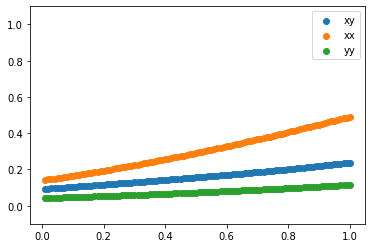

In [16]:
dataset = model.dataloader(C, V, batch_size=10)
corrs = trainer.predict_network(model, dataset)
# plt.scatter(C.squeeze(), corrs[:,1,0]/(.5 * corrs[:,0,0] + .5 * corrs[:,1,1]) , label='xy')
# plt.scatter(C.squeeze(), corrs[:,0,0]/corrs[:,0,0], label='xx')
# plt.scatter(C.squeeze(), corrs[:,1,1]/corrs[:,1,1], label='yy')
plt.scatter(C.squeeze(), corrs[:,1,0], label='xy')
plt.scatter(C.squeeze(), corrs[:,0,0], label='xx')
plt.scatter(C.squeeze(), corrs[:,1,1], label='yy')
plt.ylim(-.1, 1.1)
plt.legend()
plt.show()

In [10]:
trainer.predict_network(model, dataset)

Predicting: 1396it [00:00, ?it/s]

array([[[0.10123637, 0.05761028],
        [0.05761028, 0.02591763]],

       [[0.10122853, 0.05759437],
        [0.05759437, 0.02590458]],

       [[0.1012207 , 0.05757846],
        [0.05757846, 0.02589154]],

       ...,

       [[0.1723357 , 0.04736017],
        [0.04736017, 0.01380204]],

       [[0.1725947 , 0.04733123],
        [0.04733123, 0.01378512]],

       [[0.17285388, 0.04730214],
        [0.04730214, 0.01376822]]])

In [19]:
trainer.predict_params(model, dataset)[1]

Predicting: 284it [00:00, ?it/s]

array([[[0.15314223, 0.18824098],
        [0.13650829, 0.14771406]],

       [[0.15466754, 0.19109631],
        [0.13714403, 0.14868607]],

       [[0.15619276, 0.19395161],
        [0.13777976, 0.14965802]],

       [[0.157718  , 0.19680694],
        [0.13841549, 0.15062997]],

       [[0.15924327, 0.19966225],
        [0.13905121, 0.15160196]],

       [[0.16076852, 0.20251754],
        [0.13968696, 0.15257388]],

       [[0.16229378, 0.20537288],
        [0.1403227 , 0.15354586]],

       [[0.16381907, 0.2082282 ],
        [0.14095844, 0.15451781]],

       [[0.16534433, 0.2110835 ],
        [0.14159416, 0.1554898 ]],

       [[0.1668696 , 0.21393883],
        [0.1422299 , 0.15646176]],

       [[0.16839482, 0.21679413],
        [0.14286566, 0.1574337 ]],

       [[0.1699201 , 0.21964945],
        [0.14350137, 0.15840569]],

       [[0.17144537, 0.22250475],
        [0.14413711, 0.15937766]],

       [[0.17297062, 0.22536007],
        [0.14477286, 0.16034961]],

       [[0.17449588,